In [1]:
from pydrake.all import (
    StartMeshcat
    )
from time import sleep
from generate_models import Playground
from pydrake.systems.analysis import Simulator
from manipulation.utils import RenderDiagram
from robots import IIWA
import numpy as np
from planner import ActionExecutor, connect_to_the_world
from planner import *
from environment import MovableBody
from utils import choose_closest_heuristic

import multiprocessing as mp
import os.path
import time
from collections import OrderedDict
from typing import Dict

import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.common.value import AbstractValue
from pydrake.geometry import (
    Meshcat,
    MeshcatVisualizer,
    QueryObject,
    Rgba,
    Role,
    SceneGraph,
    Sphere,
    StartMeshcat,
)
from pydrake.geometry.optimization import (
    HPolyhedron,
    IrisInConfigurationSpace,
    IrisOptions,
    LoadIrisRegionsYamlFile,
    SaveIrisRegionsYamlFile,
)
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.inverse_kinematics import InverseKinematics
from pydrake.multibody.meshcat import JointSliders
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, MultibodyPlant
from pydrake.multibody.tree import Body
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer

from manipulation import running_as_notebook
from manipulation.utils import FindDataResource
# from iris_utils import *


In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
## Setup IRIS

iris_filename = "my_iris.yaml"
iris_regions = dict()
q = []

iris_options = IrisOptions()
iris_options.iteration_limit = 10
# increase num_collision_infeasible_samples to improve the (probabilistic)
# certificate of having no collisions.
iris_options.num_collision_infeasible_samples = 3
iris_options.require_sample_point_is_contained = True
iris_options.relative_termination_threshold = 0.01
iris_options.termination_threshold = -1

# Additional options for this notebook:

# If use_existing_regions_as_obstacles is True, then iris_regions will be
# shrunk by regions_as_obstacles_margin, and then passed to
# iris_options.configuration_obstacles.
use_existing_regions_as_obstacles = True
regions_as_obstacles_scale_factor = 0.95

# We can compute some regions in parallel.
num_parallel = mp.cpu_count()

#####

playground = Playground(meshcat=meshcat, time_step=0.001)
iiwa = IIWA(playground.construct_welded_sim(playground.default_continuous_state()))

IIWA self-collision filtering applied.
Plant init:  [ 0.5   0.6   0.   -1.75  0.    1.    0.   -0.05  0.05  1.    0.    0.
  0.    0.    0.    0.  ]
IIWA self-collision filtering applied.
Iiwa initialized


# Helper functions

In [4]:
def ScaleHPolyhedron(hpoly, scale_factor):
    # Shift to the center.
    xc = hpoly.ChebyshevCenter()
    A = hpoly.A()
    b = hpoly.b() - A @ xc
    # Scale
    b = scale_factor * b
    # Shift back
    b = b + A @ xc
    return HPolyhedron(A, b)


def _CheckNonEmpty(region):
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(region.ambient_dimension())
    region.AddPointInSetConstraints(prog, x)
    result = Solve(prog)
    assert result.is_success()


def _CalcRegion(name, seed):
    # builder = DiagramBuilder()
    # plant = AddMultibodyPlantSceneGraph(builder, 0.0)[0]
    # LoadRobot(plant)
    # plant.Finalize()
    # diagram = builder.Build()
    diagram_context = iiwa.diagram.CreateDefaultContext()
    plant_context = iiwa.plant.GetMyContextFromRoot(diagram_context)
    iiwa.plant.SetPositions(plant_context, seed)
    if use_existing_regions_as_obstacles:
        iris_options.configuration_obstacles = [
            ScaleHPolyhedron(r, regions_as_obstacles_scale_factor)
            for k, r in iris_regions.items()
            if k != name
        ]
        for h in iris_options.configuration_obstacles:
            _CheckNonEmpty(h)
    else:
        iris_options.configuration_obstacles = None
    display(f"Computing region for seed: {name}")
    start_time = time.time()
    hpoly = IrisInConfigurationSpace(iiwa.plant, plant_context, iris_options)
    display(
        f"Finished seed {name}; Computation time: {(time.time() - start_time):.2f} seconds"
    )

    _CheckNonEmpty(hpoly)
    reduced = hpoly.ReduceInequalities()
    _CheckNonEmpty(reduced)

    return reduced


def GenerateRegion(name, seed):
    global iris_regions
    iris_regions[name] = _CalcRegion(name, seed)
    SaveIrisRegionsYamlFile(f"{iris_filename}.autosave", iris_regions)


def GenerateRegions(seed_dict, verbose=True):
    if use_existing_regions_as_obstacles:
        # Then run serially
        for k, v in seed_dict.items():
            GenerateRegion(k, v)
        return

    loop_time = time.time()
    with mp.Pool(processes=num_parallel) as pool:
        new_regions = pool.starmap(_CalcRegion, [[k, v] for k, v in seed_dict.items()])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    global iris_regions
    iris_regions.update(dict(list(zip(seed_dict.keys(), new_regions))))


def DrawRobot(query_object: QueryObject, meshcat_prefix: str, draw_world: bool = True):
    rgba = Rgba(0.7, 0.7, 0.7, 0.3)
    role = Role.kProximity
    # This is a minimal replication of the work done in MeshcatVisualizer.
    inspector = query_object.inspector()
    for frame_id in inspector.GetAllFrameIds():
        if frame_id == inspector.world_frame_id():
            if not draw_world:
                continue
            frame_path = meshcat_prefix
        else:
            frame_path = f"{meshcat_prefix}/{inspector.GetName(frame_id)}"
        frame_path.replace("::", "/")
        frame_has_any_geometry = False
        for geom_id in inspector.GetGeometries(frame_id, role):
            path = f"{frame_path}/{geom_id.get_value()}"
            path.replace("::", "/")
            meshcat.SetObject(path, inspector.GetShape(geom_id), rgba)
            meshcat.SetTransform(path, inspector.GetPoseInFrame(geom_id))
            frame_has_any_geometry = True

        if frame_has_any_geometry:
            X_WF = query_object.GetPoseInWorld(frame_id)
            meshcat.SetTransform(frame_path, X_WF)


def VisualizeRegion(region_name, num_to_draw=30, draw_illustration_role_once=True):
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along it. Repeat
    """

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    LoadRobot(plant)
    plant.Finalize()
    if draw_illustration_role_once:
        MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)

    global iris_regions
    region = iris_regions[region_name]

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    diagram.ForcedPublish(context)

    query = scene_graph.get_query_output_port().Eval(scene_graph_context)
    DrawRobot(query, f"{region_name}/0", True)

    rng = np.random.default_rng()
    nq = plant.num_positions()
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(region.A(), 0 * region.b() - np.inf, region.b(), qvar)
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    for i in range(1, num_to_draw):
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q = result.GetSolution(qvar)
        plant.SetPositions(plant_context, q)
        query = scene_graph.get_query_output_port().Eval(scene_graph_context)
        DrawRobot(query, f"{region_name}/{i}", False)


def VisualizeRegions():
    for k in iris_regions.keys():
        meshcat.Delete()
        VisualizeRegion(k)
        button_name = f"Visualizing {k}; Press for next region"
        meshcat.AddButton(button_name, "Enter")
        print("Press Enter to visualize the next region")
        while meshcat.GetButtonClicks(button_name) < 1:
            time.sleep(1.0)
        meshcat.DeleteButton(button_name)


# TODO(russt): See https://github.com/RobotLocomotion/drake/pull/19520
class PoseSelector(LeafSystem):
    def __init__(
        self,
        body_index=None,
    ):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()])
        )
        self.DeclareAbstractOutputPort(
            "pose",
            lambda: AbstractValue.Make(RigidTransform()),
            self.CalcOutput,
        )

    def CalcOutput(self, context, output):
        body_poses = self.get_input_port().Eval(context)
        output.set_value(body_poses[self._body_index])

In [10]:
def MyInverseKinematics(X_WE):
    # if not plant:
    #     plant = MultibodyPlant(0.0)
    #     LoadRobot(plant)
    #     plant.Finalize()
    # if not context:
    #     
    # E = ee_body.body_frame()
    context = iiwa.plant.CreateDefaultContext()
    E = iiwa.plant.GetBodyByName("body").body_frame()

    ik = InverseKinematics(iiwa.plant, context)

    ik.AddPositionConstraint(
        E, [0, 0, 0], iiwa.plant.world_frame(), X_WE.translation(), X_WE.translation()
    )

    ik.AddOrientationConstraint(
        E, RotationMatrix(), iiwa.plant.world_frame(), X_WE.rotation(), 0.001
    )

    prog = ik.get_mutable_prog()
    q = ik.q()

    q0 = iiwa.plant.GetPositions(context)
    prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
    prog.SetInitialGuess(q, q0)
    result = Solve(ik.prog())
    if not result.is_success():
        print("IK failed")
        return None
    iiwa.plant.SetPositions(context, result.GetSolution(q))
    return result.GetSolution(q)

In [5]:
if os.path.isfile(iris_filename):
    iris_regions.update(LoadIrisRegionsYamlFile(iris_filename))
    print(f"Loaded iris regions from {iris_filename}.")
else:
    print(f"{iris_filename} not found. No previously computed regions were loaded.")

my_iris.yaml not found. No previously computed regions were loaded.


## Collision geometry details

In [6]:
def CollisionGeometryReport():
    # builder = DiagramBuilder()
    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    # LoadRobot(plant)
    # plant.Finalize()
    # diagram = builder.Build()
    context = iiwa.diagram.CreateDefaultContext()
    plant_context = iiwa.plant.GetMyContextFromRoot(context)

    query_object = iiwa.plant.get_geometry_query_input_port().Eval(plant_context)
    inspector = query_object.inspector()
    pairs = inspector.GetCollisionCandidates()
    for geomA, geomB in pairs:
        frameA = inspector.GetFrameId(geomA)
        frameB = inspector.GetFrameId(geomB)
        print(
            f"{inspector.GetName(geomA)} (in {inspector.GetName(frameA)}) + {inspector.GetName(geomB)} (in {inspector.GetName(frameB)})"
        )

CollisionGeometryReport()

iiwa::iiwa_link_2_collision (in iiwa::iiwa_link_2) + shelves_1::right_wall (in shelves_1::shelves_body)
wsg::collision (in wsg::body) + thing_1::brick_box (in thing_1::brick_center)
wsg::right_tip (in wsg::right_finger) + shelves_1::top (in shelves_1::top_and_bottom)
wsg::collision (in wsg::left_finger) + shelves_2::left_wall (in shelves_2::shelves_body)
iiwa::iiwa_link_0_collision (in iiwa::iiwa_link_0) + wsg::collision (in wsg::left_finger)
iiwa::iiwa_link_4_collision (in iiwa::iiwa_link_4) + shelves_1::shelf_upper (in shelves_1::top_and_bottom)
iiwa::iiwa_link_7_collision (in iiwa::iiwa_link_7) + shelves_1::shelf_lower (in shelves_1::top_and_bottom)
iiwa::iiwa_link_4_collision (in iiwa::iiwa_link_4) + shelves_2::left_wall (in shelves_2::shelves_body)
wsg::collision (in wsg::left_finger) + wsg::right_tip (in wsg::right_finger)
iiwa::iiwa_link_6_collision (in iiwa::iiwa_link_6) + shelves_2::bottom (in shelves_2::top_and_bottom)
iiwa::iiwa_link_6_collision (in iiwa::iiwa_link_6) + wsg:

## Run IRIS on manually-specified seeds

In [7]:
seeds = OrderedDict()
seeds["Home Position"] = iiwa.get_robot_nominal_position()
seeds["Front Shelve 1"] = np.array([0.75778046, -0.15025176, -0.64249042, 
                              -1.87726127, -2.51179728, 0.23095827,
                              -0.70537215, -0.05, 0.05])
seeds["Top Rack Shelve 1"] = np.array([0.8577218127779863, 1.0667040654704312, 1.33937485889043,
                                    1.4461052605134126, 2.3363107715669296, -0.7493105522005948,
                                    -1.1611574898891013, -0.05, 0.05])

iris_regions = dict()
GenerateRegions(seeds)

'Computing region for seed: Home Position'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake: Checking wsg::collision against shelves_1::right_wall has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves_1::right_wall after 47 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 6
INFO:drake: Checking wsg::collision against shelves_1::right_wall has already required 30 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves_1::right_wall after 42 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 7
INFO:drake: Checking wsg::collision against shelves_1::right_wall has already required 30 counter-example searches; still sear

'Finished seed Home Position; Computation time: 426.63 seconds'

'Computing region for seed: Front Shelve 1'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace: terminating iterations because the seed point is no longer in the region.


'Finished seed Front Shelve 1; Computation time: 45.91 seconds'

'Computing region for seed: Top Rack Shelve 1'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace: terminating iterations because the seed point is no longer in the region.


'Finished seed Top Rack Shelve 1; Computation time: 8.75 seconds'

In [16]:
p0 = np.array([7.34858533e-01 - 0.04, -2.35778741e-05, 6.24294858e-01])
R0 = RotationMatrix(np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T)  
X_WGoal = RigidTransform(R0, p0)

seed = MyInverseKinematics(X_WGoal)
GenerateRegion("Seed 3", seed)

'Computing region for seed: Seed 3'

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace: terminating iterations because the seed point is no longer in the region.


'Finished seed Seed 3; Computation time: 9.09 seconds'

In [19]:
p0 = np.array([7.34858533e-01 - 0.04, -2.35778741e-05, 6.24294858e-01])
R0 = RotationMatrix(np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T)  
X_WGoal = RigidTransform(R0, p0)

seed = MyInverseKinematics(X_WGoal)
seed

array([-0.46703898,  0.3326892 ,  0.59999243, -1.53399322, -2.74964844,
        0.28085682, -0.56446233, -0.05      ,  0.05      ])

## End effector teleop

In [ ]:
from collections import namedtuple
from copy import copy

from pydrake.all import Context, Meshcat, MeshcatPoseSliders, SceneGraph

RpyXyz = namedtuple("RpyXyz", ("roll", "pitch", "yaw", "x", "y", "z"))


# Creates an indicator "light" (a colored sphere in the workspace)
# TODO(russt): use meshcat.SetProperty(path, "color", rgba) instead
def IrisIndicator(
    scene_graph: SceneGraph,
    scene_graph_context: Context,
    meshcat: Meshcat,
    iris_regions: Dict[str, HPolyhedron],
    p_WIndicator: list,
):
    radius = 0.1

    meshcat.SetTransform("iris_indicator", RigidTransform(p_WIndicator))

    query_object = scene_graph.get_query_output_port().Eval(scene_graph_context)
    has_collisions = query_object.HasCollisions()
    if has_collisions:
        meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(1, 0, 0, 1))

    in_any_region = False
    for r in iris_regions.values():
        if r.PointInSet(q):
            if has_collisions:
                print("You found a counter-example!")
                # TODO(russt): Automatically shrink the iris region.
            elif not in_any_region:
                in_any_region = True
                meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(0, 1, 0, 1))

    if not has_collisions and not in_any_region:
        meshcat.SetObject("iris_indicator", Sphere(radius), Rgba(0.5, 0.5, 0.5, 1))


def EndEffectorTeleop():
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)
    ee_body = LoadRobot(plant)
    plant.Finalize()

    # Set up teleop widgets.
    sliders = builder.AddSystem(
        MeshcatPoseSliders(
            meshcat,
            lower_limit=RpyXyz(roll=0, pitch=-0.5, yaw=-np.pi, x=-0.6, y=-0.8, z=0.0),
            upper_limit=RpyXyz(
                roll=2 * np.pi, pitch=np.pi, yaw=np.pi, x=0.8, y=0.3, z=1.1
            ),
        )
    )
    print(
        """
Control the end-effector position/orientation with the sliders or the keyboard:
  ┌───────┬┬───────┬┬───────┐      ┌───────┬┬───────┬┬───────┐
  │   Q   ││   W   ││   E   │      │   U   ││   I   ││   O   │
  │ roll- ││ pitch+││ roll+ │      │   z-  ││   y+  ││   z+  │
  ├───────┼┼───────┼┼───────┤      ├───────┼┼───────┼┼───────┤
  ├───────┼┼───────┼┼───────┤      ├───────┼┼───────┼┼───────┤
  │   A   ││   S   ││   D   │      │   J   ││   K   ││   L   │
  │  yaw- ││ pitch-││  yaw+ │      │   x-  ││   y-  ││   x+  │
  └───────┴┴───────┴┴───────┘      └───────┴┴───────┴┴───────┘
"""
    )

    AddDefaultVisualization(builder, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    scene_graph_context = scene_graph.GetMyContextFromRoot(context)
    sliders_context = sliders.GetMyContextFromRoot(context)

    global q
    if len(q) == 0:
        q = plant.GetPositions(plant_context)
    plant.SetPositions(plant_context, q)
    X_WE = plant.EvalBodyPoseInWorld(plant_context, ee_body)
    sliders.SetPose(X_WE)

    iris_button_name = "Compute new IRIS region"
    meshcat.AddButton(iris_button_name)
    iris_button_clicks = 0

    stop_button_name = "Stop End Effector Teleop"
    print(
        f"Press the '{stop_button_name}' button in Meshcat to continue or press 'Escape'"
    )
    meshcat.AddButton(stop_button_name, "Escape")

    diagram.ForcedPublish(context)
    if not running_as_notebook:
        return

    while meshcat.GetButtonClicks(stop_button_name) < 1:
        # Check if the sliders have changed.
        new_X_WE = copy(sliders.get_output_port().Eval(sliders_context))

        if meshcat.GetButtonClicks(iris_button_name) > iris_button_clicks:
            iris_button_clicks = meshcat.GetButtonClicks(iris_button_name)
            # TODO(russt): Get the name from meshcat (#19666)
            region_name = "EETeleopRegion"
            region_num = 0
            while f"{region_name}{region_num}" in iris_regions.keys():
                region_num += 1
            meshcat.AddButton("Generating region (please wait)")
            GenerateRegion(
                f"{region_name}{region_num}", plant.GetPositions(plant_context)
            )
            meshcat.DeleteButton("Generating region (please wait)")
        elif X_WE.IsExactlyEqualTo(new_X_WE):
            time.sleep(1e-3)
            continue

        X_WE = new_X_WE
        q_ik = MyInverseKinematics(X_WE, plant, plant_context)
        if q_ik is not None:
            q = q_ik
            plant.SetPositions(plant_context, q)
            IrisIndicator(
                scene_graph,
                scene_graph_context,
                meshcat,
                iris_regions,
                p_WIndicator=[1, 1, 1],
            )
            diagram.ForcedPublish(context)

    meshcat.DeleteAddedControls()
    q = plant.GetPositions(plant_context)


EndEffectorTeleop()

## Visualize Conectivity

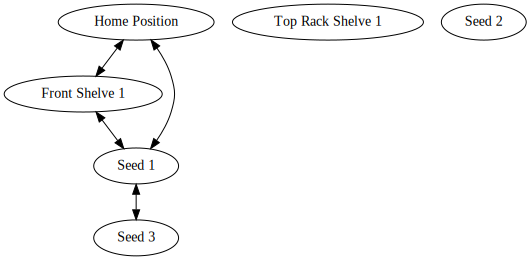

In [17]:
def VisualizeConnectivity():
    graph = pydot.Dot("IRIS region connectivity")
    keys = list(iris_regions.keys())
    for k in keys:
        graph.add_node(pydot.Node(k))
    for i in range(len(keys)):
        v1 = iris_regions[keys[i]]
        for j in range(i + 1, len(keys)):
            v2 = iris_regions[keys[j]]
            if v1.IntersectsWith(v2):
                graph.add_edge(pydot.Edge(keys[i], keys[j], dir="both"))
    display(SVG(graph.create_svg()))

VisualizeConnectivity()

## Plan trajectories with GCS Trajectory Optimization

In [32]:
from pydrake.geometry.optimization import GraphOfConvexSetsOptions, Point
from pydrake.planning import GcsTrajectoryOptimization


def PublishPositionTrajectory(
    trajectory, root_context, plant, visualizer, time_step=1.0 / 33.0
):
    """
    Args:
        trajectory: A Trajectory instance.
    """
    plant_context = plant.GetMyContextFromRoot(root_context)
    visualizer_context = visualizer.GetMyContextFromRoot(root_context)

    visualizer.StartRecording(False)

    for t in np.append(
        np.arange(trajectory.start_time(), trajectory.end_time(), time_step),
        trajectory.end_time(),
    ):
        root_context.SetTime(t)
        plant.SetPositions(plant_context, trajectory.value(t))
        visualizer.ForcedPublish(visualizer_context)

    visualizer.StopRecording()
    visualizer.PublishRecording()


def GcsTrajOpt(q_start, q_goal):
    if not iris_regions:
        print(
            "No IRIS regions loaded. Make some IRIS regions then come back and try this again."
        )
        return
    assert len(q_start) == len(q_goal)
    assert len(q_start) == iris_regions[next(iter(iris_regions))].ambient_dimension()

    # builder = DiagramBuilder()
    # plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    # # LoadRobot(plant)
    # plant.Finalize()
    # AddDefaultVisualization(builder, meshcat)
    # diagram = builder.Build()

    gcs = GcsTrajectoryOptimization(len(q_start))
    # TODO(russt): AddRegions should take named regions.
    regions = gcs.AddRegions(list(iris_regions.values()), order=1)
    source = gcs.AddRegions([Point(q_start)], order=0)
    target = gcs.AddRegions([Point(q_goal)], order=0)
    gcs.AddEdges(source, regions)
    gcs.AddEdges(regions, target)
    gcs.AddTimeCost()
    gcs.AddVelocityBounds(
        iiwa.get_bounded_velocity_lower_limit(), iiwa.get_bounded_velocity_upper_limit()
    )

    options = GraphOfConvexSetsOptions()
    options.preprocessing = True
    options.max_rounded_paths = 5
    start_time = time.time()
    traj, result = gcs.SolvePath(source, target, options)
    print(type(traj))
    print(f"GCS solved in {time.time() - start_time} seconds")
    if not result.is_success():
        print("Could not find a feasible path from q_start to q_goal")
        return

    PublishPositionTrajectory(
        traj,
        iiwa.diagram.CreateDefaultContext(),
        iiwa.plant,
        playground.diagram.GetSubsystemByName("meshcat_visualizer(illustration)"),
    )

In [33]:
seeds["Seed 3"] = np.array([-0.46703898,  0.3326892 ,  0.59999243, 
                             -1.53399322, -2.74964844,  0.28085682,
                             -0.56446233, -0.05      ,  0.05      ])
assert (
    seeds
), "The examples here use the 'manually-specified seeds' from the section above. Please run that section first, or populate your own start and end configurations."

GcsTrajOpt(seeds["Home Position"], seeds["Seed 3"])
# GcsTrajOpt(seeds["Above Shelve"], seeds["Top Rack"])

INFO:drake:Solved GCS shortest path using Clp with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Found 2 unique paths, discarded 98 duplicate paths.
INFO:drake:Finished 2 rounding solutions with Clp.


<class 'pydrake.trajectories.CompositeTrajectory'>
GCS solved in 0.30176877975463867 seconds


RuntimeError: A function call on a drake::systems::Diagram<double> system named '::environment' was passed the Context of a system named '::environment_welded' instead of the appropriate subsystem Context.
For more information about Context-System mismatches, see https://drake.mit.edu/troubleshooting.html#framework-context-system-mismatch

In [21]:
seeds["Home Position"]

array([ 0.5 ,  0.6 ,  0.  , -1.75,  0.  ,  1.  ,  0.  , -0.05,  0.05])

In [30]:
if running_as_notebook:
    SaveIrisRegionsYamlFile(iris_filename, iris_regions)

In [31]:
if os.path.exists("/tmp/mosek.lic"):
    os.remove("/tmp/mosek.lic")